In [1]:
import numpy as np
import numpy
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from time import time
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub
import tensorflow_probability
tfd = tensorflow_probability.distributions
from tensorflow.contrib.opt import ScipyOptimizerInterface 
# tf.enable_eager_execution()

In [3]:
sys.path.append('../code/utils/')
sys.path.append('../code/flowpm/')
import tools
from background import *
import tfpm 
import tfpmfuncs as tfpf
from tfpmconfig import Config
from layers import wide_resnet
import datalib as dlib
import datatools as dtools


In [4]:

#############################
seed_in = 3
from numpy.random import seed
seed(seed_in)
from tensorflow import set_random_seed
set_random_seed(seed_in)

bs = 400
nc, ncf = 128, 512
ncp = 128
step, stepf = 5, 40
path = '/data2/cosmo4d/'
ftype = 'L%04d_N%04d_S%04d_%02dstep/'
numd = 1e-3
num = int(numd*bs**3)
R1 = 3
R2 = 3*1.2
kny = np.pi*ncp/bs
kk = tools.fftk((ncp, ncp, ncp), bs)
seeds = [100]
rprob = 0.5
shape = (nc, nc, nc)

In [5]:
suff = 'pad2'
ftname = ['cic']
nchannels = len(ftname)


num_cubes= 1000
cube_size = 32
max_offset = ncp - cube_size
pad = 2
cube_sizeft = cube_size + 2*pad

In [6]:
#############################
##Read data and generate meshes
#mesh = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'mesh/d/')
meshes = {}
cube_features, cube_target = [], []

for seed in seeds:
    mesh = {}
    partp = tools.readbigfile(path + ftype%(bs, nc, seed, step) + 'dynamic/1/Position/')
    mesh['cic'] = tools.paintcic(partp, bs, ncp)
    #mesh['decic'] = tools.decic(mesh['cic'], kk, kny)
    mesh['R1'] = tools.fingauss(mesh['cic'], kk, R1, kny)
    #mesh['R2'] = tools.fingauss(mesh['cic'], kk, R2, kny)
    #mesh['GD'] = mesh['R1'] - mesh['R2']

    hmesh = {}
    hpath = path + ftype%(bs, ncf, seed, stepf) + 'galaxies_n05/galcat/'
    hposd = tools.readbigfile(hpath + 'Position/')
    massd = tools.readbigfile(hpath + 'Mass/').reshape(-1)*1e10
    galtype = tools.readbigfile(hpath + 'gal_type/').reshape(-1).astype(bool)
    #hposall = tools.readbigfile(path + ftype%(bs, ncf, seed, stepf) + 'FOF/PeakPosition/')[1:]    
    #hposd = hposall[:num].copy()
    #massd = massall[:num].copy()
    #hmesh['pcic'] = tools.paintcic(hposd, bs, nc)
    hmesh['pnn'] = tools.paintnn(hposd, bs, ncp)
    #hmesh['mnn'] = tools.paintnn(hposd, bs, ncp, massd)
    hmesh['pnnsat'] = tools.paintnn(hposd[galtype], bs, ncp)
    hmesh['pnncen'] = tools.paintnn(hposd[~galtype], bs, ncp)

    meshes[seed] = [mesh, hmesh]

    print('All the mesh have been generated for seed = %d'%seed)

    #Create training voxels
    ftlist = [mesh[i].copy() for i in ftname]
    ftlistpad = [np.pad(i, pad, 'wrap') for i in ftlist]
    targetmesh = [hmesh['pnncen'], hmesh['pnnsat']]
    ntarget = len(targetmesh)
    
    features, target = dtools.randomvoxels(ftlistpad, targetmesh, num_cubes, max_offset, cube_size, cube_sizeft,
                                           seed=seed, rprob=rprob)
    cube_features = cube_features + features
    cube_target = cube_target + target

#
cube_target = np.stack(cube_target,axis=0).reshape((-1,cube_size,cube_size,cube_size, ntarget))
cube_features = np.stack(cube_features,axis=0).reshape((-1,cube_sizeft,cube_sizeft,cube_sizeft,nchannels))
print(cube_target[0].shape)
print(cube_features[0].shape)
trainingsize = cube_features.shape[0]
print('Training size is = ', trainingsize)


All the mesh have been generated for seed = 100
Length of targets =  2
Supplemented by rotation :  497
(32, 32, 32, 2)
(36, 36, 36, 1)
Training size is =  1497


# Halos

In [7]:
tf.reset_default_graph()

#                                                                                                                                           
niter = 9000
sess = tf.Session()
chkname = suff #+'_it%d'%niter                                                                                                              


In [8]:
tf.reset_default_graph()
module = hub.Module('modules/1544168303/likelihood')
xx = tf.placeholder(tf.float32, shape=[None, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
yy = tf.placeholder(tf.float32, shape=[None, cube_size, cube_size, cube_size, 2], name='labels')
likelihood = module(dict(features=xx, labels=yy), as_dict=True)['loglikelihood']

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
        
    for seed in seeds:
        
        features = cube_features[8:16].astype('float32')
        targets = cube_target[0:8].astype('float32')
        
        recp = sess.run(likelihood, feed_dict={xx:features, yy:targets})


In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'seed', 'shape', 'pad', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [11]:
recp.shape

(8, 32, 32, 32, 2)

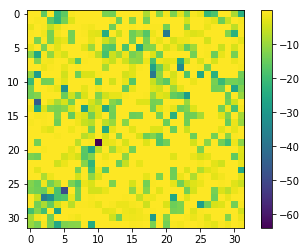

In [12]:
# This is likelihood for different input
imshow(recp[0,:,:,:,0].sum(axis=0));colorbar()

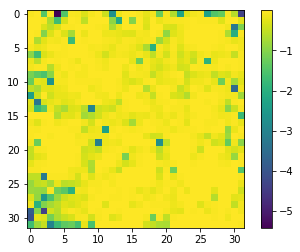

In [21]:
# This is likelihood for corresponding input
imshow(recp[0,:,:,:,0].sum(axis=0));colorbar()

# Recon single voxel here


In [13]:
cube_features[0].shape

(36, 36, 36, 1)

In [14]:
cube_target[0].shape

(32, 32, 32, 2)

In [31]:
##Do optimization here
##############################                                                                                                              
##MODEL HERE
#                                                                                                                                           
####################################
#Select data voxel
recontruth = reshape(cube_features[0], (1,36,36,36,nchannels))
reconmapp = reshape(cube_target[0], (1,32,32,32,2))
####################################


losses = []
niter = 1000
def call_loss(l):
    if len(losses) % (niter//10) == 0: print(l)
    losses.append(l)

    
tf.reset_default_graph()
chkname = suff #+'_it%d'%niter                                                                                                              


module = hub.Module('modules/1544168303/likelihood')
xx = tf.get_variable(name='xopt', shape=[1, cube_sizeft, cube_sizeft, cube_sizeft, nchannels]
                       ,initializer=tf.random_normal_initializer(mean=5,stddev=2), trainable=True)

yy = tf.placeholder(tf.float32, shape=[1, cube_size, cube_size, cube_size, 2], name='labels')

likelihood = module(dict(features=xx, labels=yy), as_dict=True)['loglikelihood']

loss = - tf.reduce_sum(likelihood)

###############

###GD
optimizer = tf.train.GradientDescentOptimizer(learning_rate=10)
opt_op = optimizer.minimize(loss, var_list=[xx])

##optimize
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())

    val0 = sess.run(xx)

    for it in range(niter+1):
        _, l = sess.run([opt_op, loss], feed_dict={yy:reconmapp})
        if it % (niter//10) == 0:
            print('Iter %d of %d : Loss= %0.4f\n'%(it, niter, l))
        losses.append(l)

    #save reconstruced voxel
    recon = sess.run(xx)
#     outtruth = sess.run(output, feed_dict={xx:recontruth, yy:reconmapp})
#     outrecon = sess.run(output, feed_dict={xx:recon, yy:reconmapp})

###############

###Scipy
# optimizer = ScipyOptimizerInterface(loss, var_list=[xx], method='CG', options={'maxiter': niter})
# with tf.Session() as sess:
#     sess.run(tf.initializers.global_variables())

#     val0 = sess.run(xx)

#     optimizer.minimize(sess, feed_dict={yy:reconmapp}, loss_callback=call_loss, fetches=[loss])

#     #save reconstruced voxel
#     recon = sess.run(xx)
#     outtruth = sess.run(output, feed_dict={xx:recontruth, yy:reconmapp})
#     outrecon = sess.run(output, feed_dict={xx:recon, yy:reconmapp})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Iter 0 of 1000 : Loss= 9887.8896

Iter 100 of 1000 : Loss= 92.2077

Iter 200 of 1000 : Loss= 66.8313

Iter 300 of 1000 : Loss= 53.4715

Iter 400 of 1000 : Loss= 48.1914

Iter 500 of 1000 : Loss= 38.6809

Iter 600 of 1000 : Loss= 36.5711

Iter 700 of 1000 : Loss= 34.6835

Iter 800 of 1000 : Loss= 33.6577

Iter 900 of 1000 : Loss= 32.7390

Iter 1000 of 1000 : Loss= 30.5942



Text(0.5, 1.0, 'Difference')

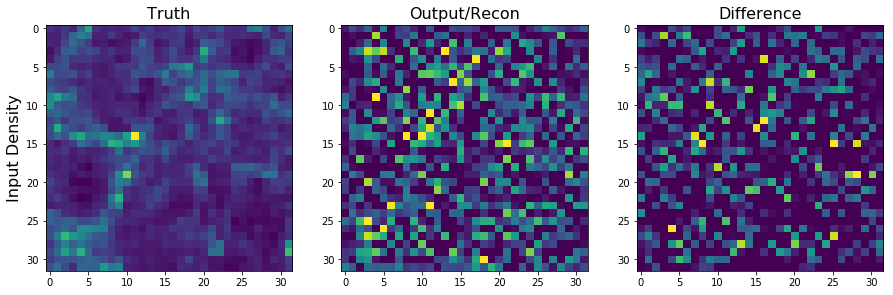

In [32]:
def getim(ar, axis=0):
    return ar[0, 2:-2, 2:-2, 2:-2, 0].sum(axis=axis)

fsize = 16
figure(figsize=(15,5))
vmin, vmax = getim(recontruth).min(), getim(recontruth).max()
subplot(131)
imshow(getim(recontruth), vmin=vmin, vmax=vmax)
ylabel('Input Density', fontsize=fsize)
title('Truth', fontsize=fsize)
subplot(132)
imshow(getim(recon), vmin=vmin, vmax=vmax)
title('Output/Recon', fontsize=fsize)
subplot(133)
imshow(getim(recontruth-recon), vmin=vmin, vmax=vmax)
title('Difference', fontsize=fsize)

## Scipy LBFGS recon

In [75]:
tf.reset_default_graph()

def reconmodel(config, modpath, data, sigma=0.01**0.5, maxiter=1000):

    bs, nc = config['boxsize'], config['nc']
    print(bs, nc)
    kmesh = sum(kk**2 for kk in config['kvec'])**0.5
    priorwt = config['ipklin'](kmesh) * bs ** -3 
    
    g = tf.Graph()

    with g.as_default():
        
        
        module = hub.Module(modpath)
        initlin = tf.placeholder(tf.float32, ( cube_sizeft, cube_sizeft, cube_sizeft), name='initlin')
        linear = tf.get_variable('linmesh', shape=(nc, nc, nc), 
                             initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
#         linear = tf.get_variable('linmesh', shape=(nc, nc, nc), 
#                              initializer=tf.initializers.ones(), trainable=True)
        initlin_op = linear.assign(initlin, name='initlin_op')
        #PM
        icstate = tfpm.lptinit(linear, config, name='icstate')
        fnstate = tfpm.nbody(icstate, config, verbose=False, name='fnstate')
        final = tf.zeros_like(linear)
        final = tfpf.cic_paint(final, fnstate[0], boxsize=bs, name='final')
        #
    
        xx = tf.reshape(final, shape=[-1, cube_sizeft, cube_sizeft, cube_sizeft, nchannels], name='input')
        #Halos
#         yy = tf.reshape(data, shape=[-1, cube_size, cube_size, cube_size, 1], name='labels')
        yy = data
        likelihood = module(dict(features=tf.cast(xx, tf.float32), labels=tf.cast(yy, tf.float32)), as_dict=True)['loglikelihood']

        chisq = - tf.reduce_sum(likelihood)
        
        #Prior
        lineark = tfpf.r2c3d(linear, norm=nc**3)
        priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
        prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
        prior = tf.multiply(prior, 1/nc**3, name='prior')
#         prior = tf.multiply(prior, 1, name='prior')

        #
        loss = tf.add(chisq, prior, name='loss')
        
#         optimizer = ScipyOptimizerInterface(loss, var_list=[linear], method='CG', options={'maxiter': maxiter})
        optimizer = ScipyOptimizerInterface(loss, var_list=[linear], options={'maxiter': maxiter})
        
        tf.add_to_collection('inits', [initlin_op, initlin])
        tf.add_to_collection('opt', optimizer)
        tf.add_to_collection('diagnostics', [prior, chisq, loss])
        tf.add_to_collection('reconpm', [linear, final])
        tf.add_to_collection('data', data)
    return g
    



In [76]:
#Select data voxel
recontruth = reshape(cube_features[0], (1,36,36,36,nchannels))
reconmapp = reshape(cube_target[0], (1,32,32,32,2))
####################################
####################################

pkfile = '../code/flowpm/Planck15_a1p00.txt'
config = Config(bs=400./128*cube_sizeft, nc=cube_sizeft, seed=999, pkfile=pkfile)
bs, nc = config['boxsize'], config['nc']
modpath = 'modules/1544168303/likelihood'

reconh = reconmodel(config, modpath, reconmapp, maxiter=1000)

112.5 36


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  import sys


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [77]:
losses = []
def call_loss(l):
#     if len(losses) % (niter//10) == 0: print(l)
    print(l)
    losses.append(l)

    
with tf.Session(graph=reconh) as session:
    g = session.graph
    session.run(tf.global_variables_initializer())
    linmesh = g.get_tensor_by_name("linmesh:0")
    finmesh = g.get_tensor_by_name("final:0")
    #hmesh = g.get_tensor_by_name("prediction:0")#reconh.get_collection_ref('reconpm')[0][-1]
    optimizer = g.get_collection_ref('opt')[0]
    loss = g.get_tensor_by_name('loss:0')
    prior = g.get_tensor_by_name('prior:0')

    init = session.run(linmesh)
    optimizer.minimize(session, loss_callback=call_loss, fetches=[[loss, prior]])
    print(session.run([loss, prior]))
    recon = session.run(linmesh)
    frecon = session.run(finmesh)
    #hrecon = session.run(hmesh)


[4706.083, 57.824696]
[4626.4062, 57.8211]
[4334.908, 57.80677]
[2882.538, 57.62313]
[2000.7478, 57.40035]
[1519.9052, 57.165203]
[1208.9921, 56.851536]
[980.20856, 56.465477]
[831.8461, 56.087643]
[716.47076, 55.74576]
[628.1371, 55.353485]
[555.4338, 55.185318]
[507.29666, 55.047382]
[453.4547, 54.73308]
[408.74814, 54.26535]
[381.50034, 53.90494]
[351.91647, 53.802002]
[326.8626, 53.501522]
[307.922, 53.288944]
[289.01804, 52.823116]
[275.18042, 52.158913]
[259.70828, 52.055653]
[252.18304, 51.960354]
[243.70369, 51.69359]
[233.46526, 51.353924]
[223.66861, 50.835503]
[215.55699, 50.393513]
[205.97662, 49.88627]
[199.83054, 49.25498]
[194.68675, 49.1364]
[189.47653, 48.859814]
[184.17178, 48.030796]
[178.52583, 47.360676]
[173.42465, 46.743317]
[169.38548, 46.03281]
[165.05637, 45.206947]
[161.16646, 44.095547]
[157.21152, 43.982334]
[154.7445, 43.847687]
[151.1016, 43.147724]
[147.98392, 42.345512]
[144.61075, 41.675938]
[141.34431, 40.79352]
[138.29681, 39.831676]
[135.15825, 39.3

[18.107666, 1.9339195]
[18.079676, 1.9374565]
[18.055168, 1.9384266]
[18.026, 1.941468]
[18.005724, 1.9448688]
[17.98289, 1.9479326]
[17.953472, 1.9550754]
[17.928436, 1.958636]
[17.904547, 1.9605695]
[17.882626, 1.9629257]
[17.862547, 1.9656478]
[17.842178, 1.9692383]
[17.820534, 1.9727924]
[17.789736, 1.9787072]
[17.770653, 1.9836435]
[17.749498, 1.9858636]
[17.721424, 1.9890658]
[17.700663, 1.9913793]
[17.668846, 1.996967]
[17.641518, 1.9994531]
[17.626312, 2.0002565]
[17.599953, 2.0027428]
[17.579723, 2.005499]
[17.557741, 2.0091727]
[17.536825, 2.0142157]
[17.518375, 2.0161314]
[17.497534, 2.0169203]
[17.479385, 2.0192738]
[17.45992, 2.020737]
[17.441013, 2.022915]
[17.41205, 2.0269475]
[17.391577, 2.029881]
[17.372166, 2.0322216]
[17.354147, 2.0339324]
[17.336628, 2.0357094]
[17.318913, 2.037547]
[17.300932, 2.0402553]
[17.282837, 2.041787]
[17.26566, 2.0432677]
[17.246237, 2.0454981]
[17.223982, 2.0481446]
[17.205637, 2.0510926]
[17.185549, 2.055031]
[17.162685, 2.058734]
[17.14

[13.595003, 2.4533103]
[13.59017, 2.453394]
[13.583775, 2.4535038]
[13.578085, 2.4535794]
[13.57348, 2.4536183]
[13.567051, 2.453696]
[13.561909, 2.4538512]
[13.556425, 2.453968]
[13.551538, 2.454123]
[13.546103, 2.4543936]
[13.542566, 2.4545875]
[13.538038, 2.454595]
[13.531771, 2.4546564]
[13.528152, 2.4547622]
[13.522836, 2.4549286]
[13.517614, 2.4551892]
[13.51265, 2.455324]
[13.508733, 2.455325]
[13.502331, 2.4554238]
[13.496599, 2.4557426]
[13.491328, 2.4560614]
[13.48674, 2.4563673]
[13.482233, 2.4567053]
[13.477734, 2.456955]
[13.473215, 2.4570062]
[13.4675045, 2.4571726]
[13.462133, 2.4572587]
[13.4579735, 2.4574056]
[13.453091, 2.457676]
[13.4472885, 2.4580593]
[13.442323, 2.4582164]
[13.438352, 2.4583092]
[13.433491, 2.4584405]
[13.428787, 2.4585447]
[13.424193, 2.4586804]
[13.4187765, 2.459006]
[13.415457, 2.4591641]
[13.411245, 2.4591906]
[13.405457, 2.4593446]
[13.401913, 2.4594703]
[13.396398, 2.4597166]
[13.391931, 2.4599488]
[13.386795, 2.4601617]
[13.381794, 2.4602854

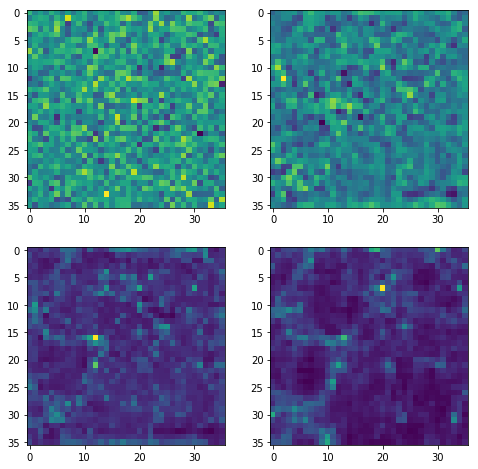

In [54]:
# After 1000 iterations
fig, ax = plt.subplots(2, 2, figsize = (8, 8))
ax[0, 0].imshow(init.sum(axis=0))
ax[0, 1].imshow(recon.sum(axis=0))

ax[1, 0].imshow(frecon.sum(axis=0))
ax[1, 1].imshow(recontruth[0, :, :, :, 0].sum(axis=0))

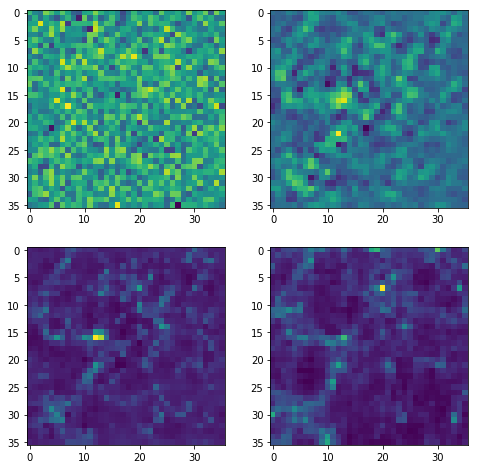

In [41]:
# After 100 iterations
fig, ax = plt.subplots(2, 2, figsize = (8, 8))
ax[0, 0].imshow(init.sum(axis=0))
ax[0, 1].imshow(recon.sum(axis=0))

ax[1, 0].imshow(frecon.sum(axis=0))
ax[1, 1].imshow(recontruth[0, :, :, :, 0].sum(axis=0))